Using device: cuda

Epoch 1/200
 [██████████████████████████████] 100.0%
Loss: 146.0493 | Accuracy: 0.6047

Epoch 2/200
 [██████████████████████████████] 100.0%
Loss: 141.2630 | Accuracy: 0.6266

Epoch 3/200
 [██████████████████████████████] 100.0%
Loss: 140.9623 | Accuracy: 0.6275

Epoch 4/200
 [██████████████████████████████] 100.0%
Loss: 140.7891 | Accuracy: 0.6301

Epoch 5/200
 [██████████████████████████████] 100.0%
Loss: 140.4143 | Accuracy: 0.6325

Epoch 6/200
 [██████████████████████████████] 100.0%
Loss: 138.1708 | Accuracy: 0.6434

Epoch 7/200
 [██████████████████████████████] 100.0%
Loss: 133.1765 | Accuracy: 0.6716

Epoch 8/200
 [██████████████████████████████] 100.0%
Loss: 131.1399 | Accuracy: 0.6814

Epoch 9/200
 [██████████████████████████████] 100.0%
Loss: 130.7035 | Accuracy: 0.6838

Epoch 10/200
 [██████████████████████████████] 100.0%
Loss: 129.5191 | Accuracy: 0.6881

Epoch 11/200
 [██████████████████████████████] 100.0%
Loss: 129.2411 | Accuracy: 0.6884

Epoch 12/2

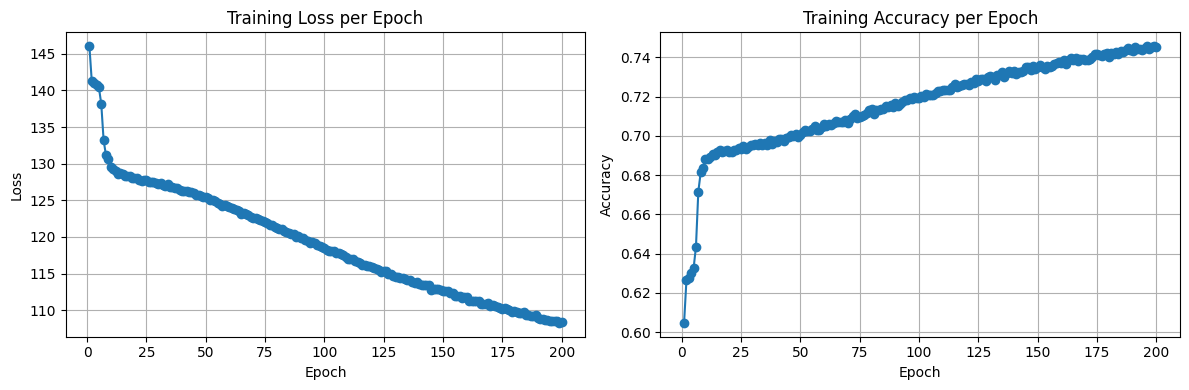

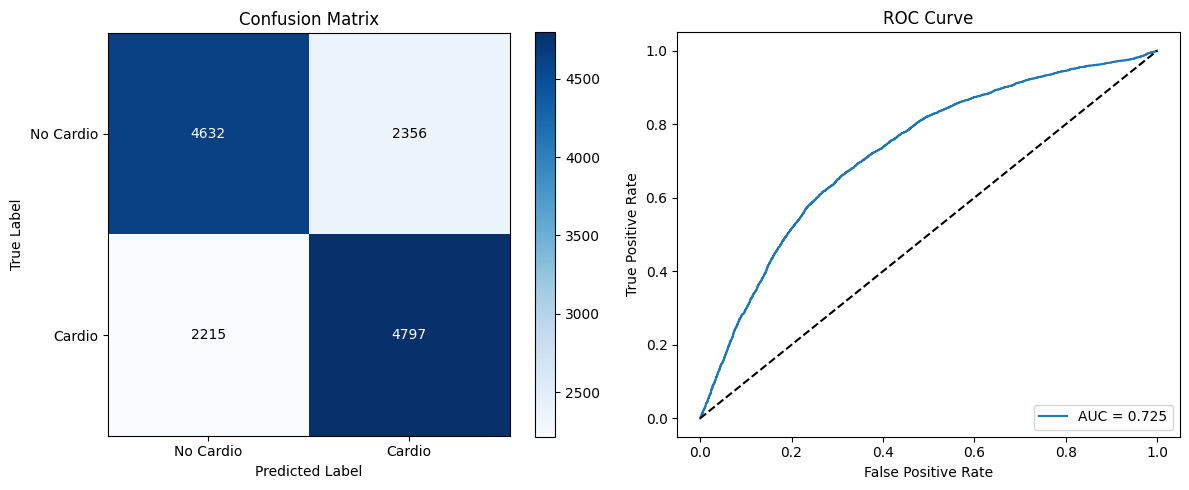

In [7]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from tab_transformer_pytorch import TabTransformer
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve, confusion_matrix
)
import numpy as np
import matplotlib.pyplot as plt
import sys

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. データ読み込み
data = pd.read_csv("cardio_train.csv", sep=';')

# 2. 特徴量指定
categorical_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
continuous_cols  = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
target_col       = 'cardio'

# 3. カテゴリ変数数値化
for col in categorical_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

# 4. 連続変数標準化
scaler = StandardScaler()
data[continuous_cols] = scaler.fit_transform(data[continuous_cols])

# 5. 訓練/テスト分割
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# 6. Dataset定義
class CardioDataset(Dataset):
    def __init__(self, df):
        self.categ  = df[categorical_cols].values.astype(np.int64)
        self.cont   = df[continuous_cols].values.astype(np.float32)
        self.labels = df[target_col].values.astype(np.float32)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return (
            torch.tensor(self.categ[idx]),
            torch.tensor(self.cont[idx]),
            torch.tensor(self.labels[idx])
        )

train_loader = DataLoader(CardioDataset(train_data), batch_size=256, shuffle=True)
test_loader  = DataLoader(CardioDataset(test_data),  batch_size=256)

# 7. モデル構築
cont_mean_std = torch.tensor([[0., 1.]] * len(continuous_cols)).to(device)
model = TabTransformer(
    categories=tuple(data[col].nunique() for col in categorical_cols),
    num_continuous=len(continuous_cols),
    dim=32,
    dim_out=1,
    depth=4,
    heads=4,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2),
    mlp_act=nn.ReLU(),
    continuous_mean_std=cont_mean_std
).to(device)
model.categories_offset = model.categories_offset.to(device)

# 8. 損失・最適化
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

# 9. 学習ループ
def train_model(model, loader, epochs):
    model.train()
    loss_history = []
    acc_history  = []
    total_batches = len(loader)

    for epoch in range(epochs):
        total_loss = 0.0
        correct, total = 0, 0
        print(f"\nEpoch {epoch+1}/{epochs}")
        for batch_idx, (x_categ, x_cont, y) in enumerate(loader):
            x_categ, x_cont, y = x_categ.to(device), x_cont.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x_categ, x_cont).squeeze(1)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # 精度計算
            prob = torch.sigmoid(out)
            pred = (prob > 0.5).int()
            correct += (pred == y.int()).sum().item()
            total += y.size(0)
            # 進捗バー
            progress = (batch_idx + 1) / total_batches * 100
            bar_len = 30
            filled = int(bar_len * progress / 100)
            bar = '█' * filled + '-' * (bar_len - filled)
            sys.stdout.write(f"\r [{bar}] {progress:5.1f}%")
            sys.stdout.flush()

        epoch_loss = total_loss
        epoch_acc  = correct / total
        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)
        print(f"\nLoss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

    return loss_history, acc_history

# 10. 評価関数
def evaluate_model(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x_categ, x_cont, y in loader:
            x_categ, x_cont, y = x_categ.to(device), x_cont.to(device), y.to(device)
            out = model(x_categ, x_cont).squeeze(1)
            prob = torch.sigmoid(out)
            pred = (prob > 0.5).int()
            preds.extend(pred.cpu().tolist())
            trues.extend(y.cpu().int().tolist())

    acc   = accuracy_score(trues, preds)
    f1    = f1_score(trues, preds)
    prec  = precision_score(trues, preds)
    rec   = recall_score(trues, preds)
    print(f"\nTest Accuracy: {acc:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    return acc, f1, prec, rec

# 11. 学習実行
losses, accs = train_model(model, train_loader, epochs=200)
evaluate_model(model, test_loader)

# 12. 学習曲線プロット
def plot_training_curves(losses, accs):
    epochs = range(1, len(losses) + 1)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(epochs, losses, marker='o')
    axs[0].set_title('Training Loss per Epoch')
    axs[0].set_xlabel('Epoch'); axs[0].set_ylabel('Loss'); axs[0].grid(True)
    axs[1].plot(epochs, accs, marker='o')
    axs[1].set_title('Training Accuracy per Epoch')
    axs[1].set_xlabel('Epoch'); axs[1].set_ylabel('Accuracy'); axs[1].grid(True)
    plt.tight_layout()
    plt.show()

plot_training_curves(losses, accs)

# 13. 混同行列＋ROCを自動表示
def plot_confusion_and_roc(model, loader):
    model.eval()
    preds, trues, probs = [], [], []

    # 予測取得
    with torch.no_grad():
        for x_categ, x_cont, y in loader:
            x_categ, x_cont, y = x_categ.to(device), x_cont.to(device), y.to(device)
            out = model(x_categ, x_cont).squeeze(1)
            prob = torch.sigmoid(out)
            pred = (prob > 0.5).int()

            preds.extend(pred.cpu().tolist())
            trues.extend(y.cpu().int().tolist())
            probs.extend(prob.cpu().tolist())

    # 混同行列とROC準備
    cm = confusion_matrix(trues, preds)
    classes = ['No Cardio', 'Cardio']
    fpr, tpr, _ = roc_curve(trues, probs)
    auc = roc_auc_score(trues, probs)

    # 描画
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # 1. 混同行列
    im = axs[0].imshow(cm, cmap='Blues')
    axs[0].set_xticks(np.arange(len(classes)))
    axs[0].set_yticks(np.arange(len(classes)))
    axs[0].set_xticklabels(classes)
    axs[0].set_yticklabels(classes)
    axs[0].set_xlabel('Predicted Label')
    axs[0].set_ylabel('True Label')
    axs[0].set_title('Confusion Matrix')

    # セル内に数値を表示
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            axs[0].text(j, i, cm[i, j], ha='center', va='center', color=color)

    # カラーバー
    fig.colorbar(im, ax=axs[0])

    # 2. ROC曲線
    axs[1].plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    axs[1].plot([0, 1], [0, 1], 'k--')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title('ROC Curve')
    axs[1].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

# 関数呼び出し例
plot_confusion_and_roc(model, test_loader)